In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import scienceplots
from tqdm import tqdm
import time

plt.style.use(['science', 'ieee'])
torch.manual_seed(1024)

# Model settings
supervised = True
if supervised == True:
    model_name = f"supervised_pinn"
else:
    model_name = f"unsupervised_pinn"

# Experiment settings
k_values = [100, 200, 300, 400]
c_values = [1, 2, 3, 4]
m_values = [0.5, 1, 1.5, 2]

t0 = 0.0
tt = 1.0

def generate_testing_data(k, c, m):
    t_test = torch.linspace(t0, tt, 1200).view(-1, 1).requires_grad_(True)
    x_test = torch.tensor(exact_function(t_test.detach().numpy(), k, c, m)).view(-1, 1).requires_grad_(True)
    return t_test, x_test

def exact_function(t, k, c, m):
    d = c / (2 * m)
    w0 = np.sqrt(k / m)

    # x(t) = exp^(-d * t) * (2A * cos(phi + w * t))
    w = np.sqrt((w0**2)-(d**2))
    phi = np.arctan(-d/w)
    A = 1 / (2 * np.cos(phi))
    x = (np.exp(-d * t)) * (2 * A * np.cos(phi + w * t))
    return x

testing_data = []

for k in k_values:
    for c in c_values:
        for m in m_values:
            t_test, x_test = generate_testing_data(k, c, m)
            testing_data.append((k, c, m, t_test, x_test))

In [2]:
# Define the neural network model
class FCNN(nn.Module):
    '''
    Define neural network architecture
    '''
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
            nn.Linear(N_INPUT, N_HIDDEN), activation()
        ])
        
        self.fch = nn.Sequential(*[
            nn.Sequential(*[
                nn.Linear(N_HIDDEN, N_HIDDEN), activation()
            ]) for _ in range(N_LAYERS)
        ])
        
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

model = FCNN(1, 1, 32, 8)

model_path = f"../../model/{model_name}.pt"
model.load_state_dict(torch.load(model_path))
print(f"Model: {model_name} loaded!")

Model: supervised_pinn loaded!


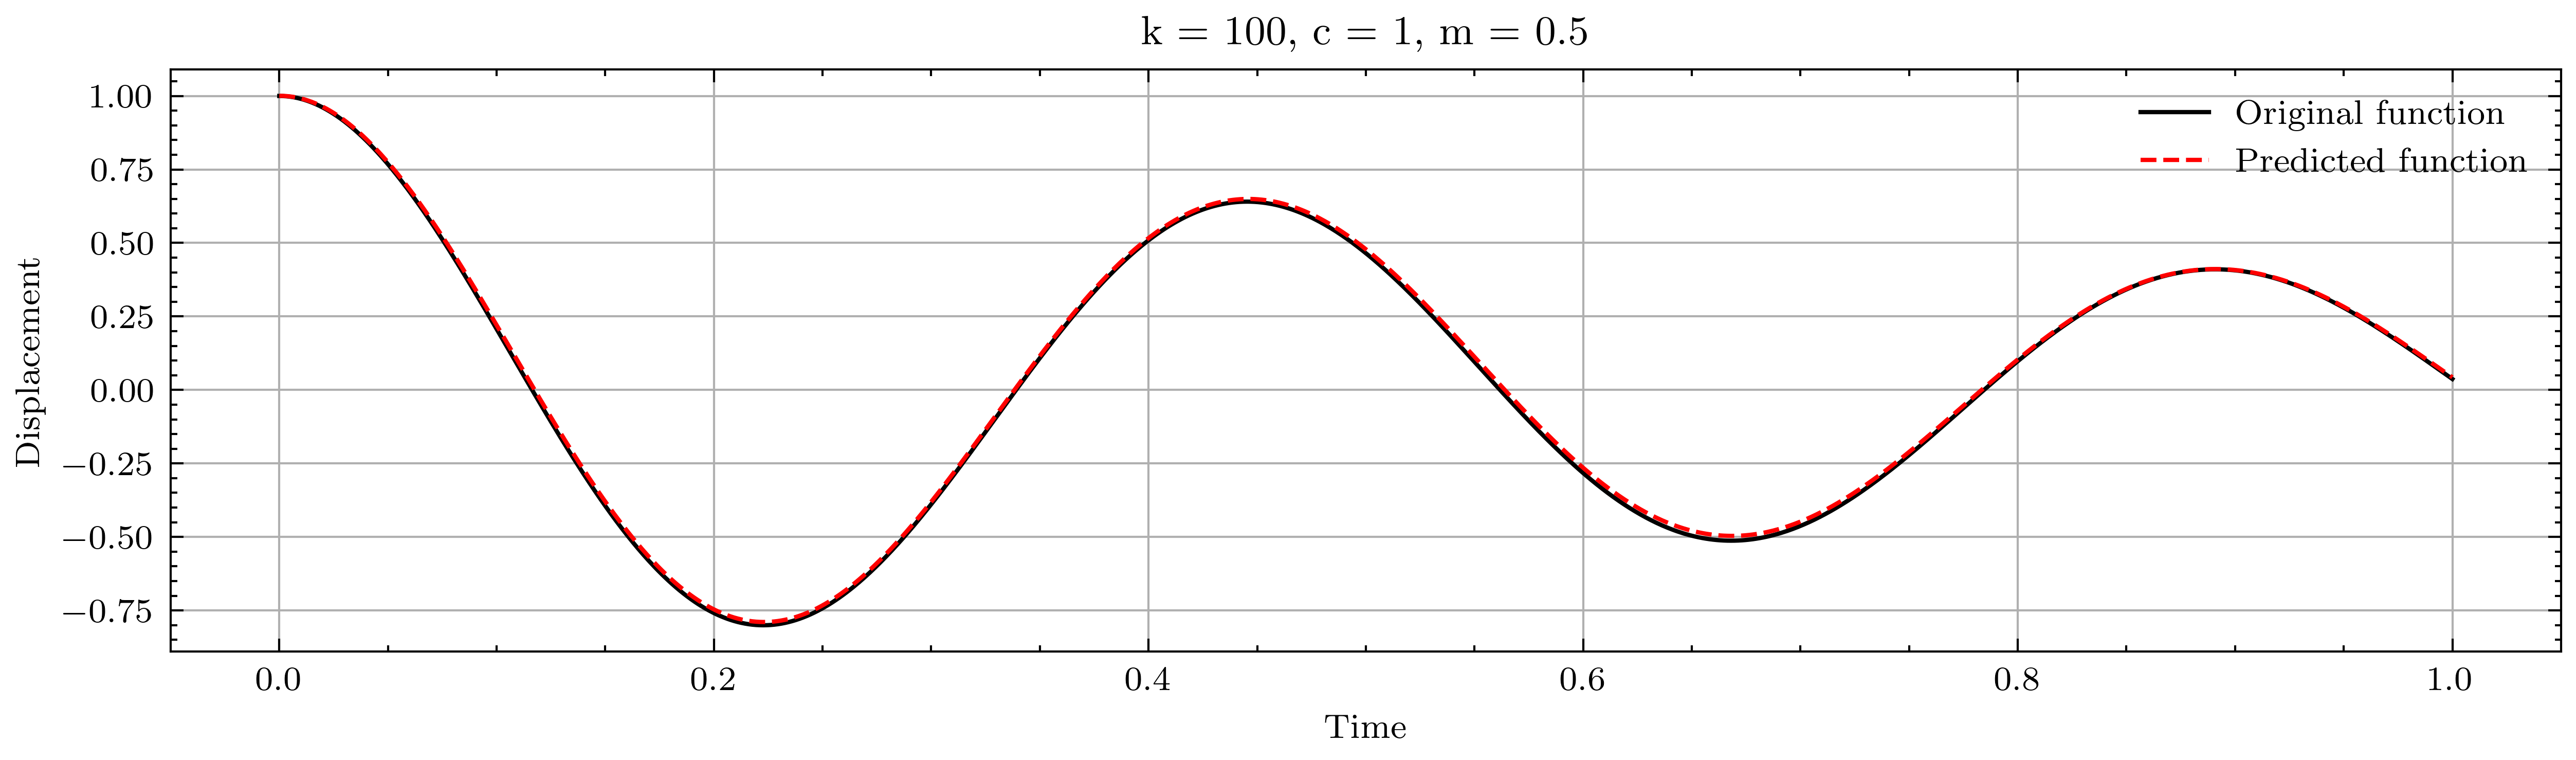

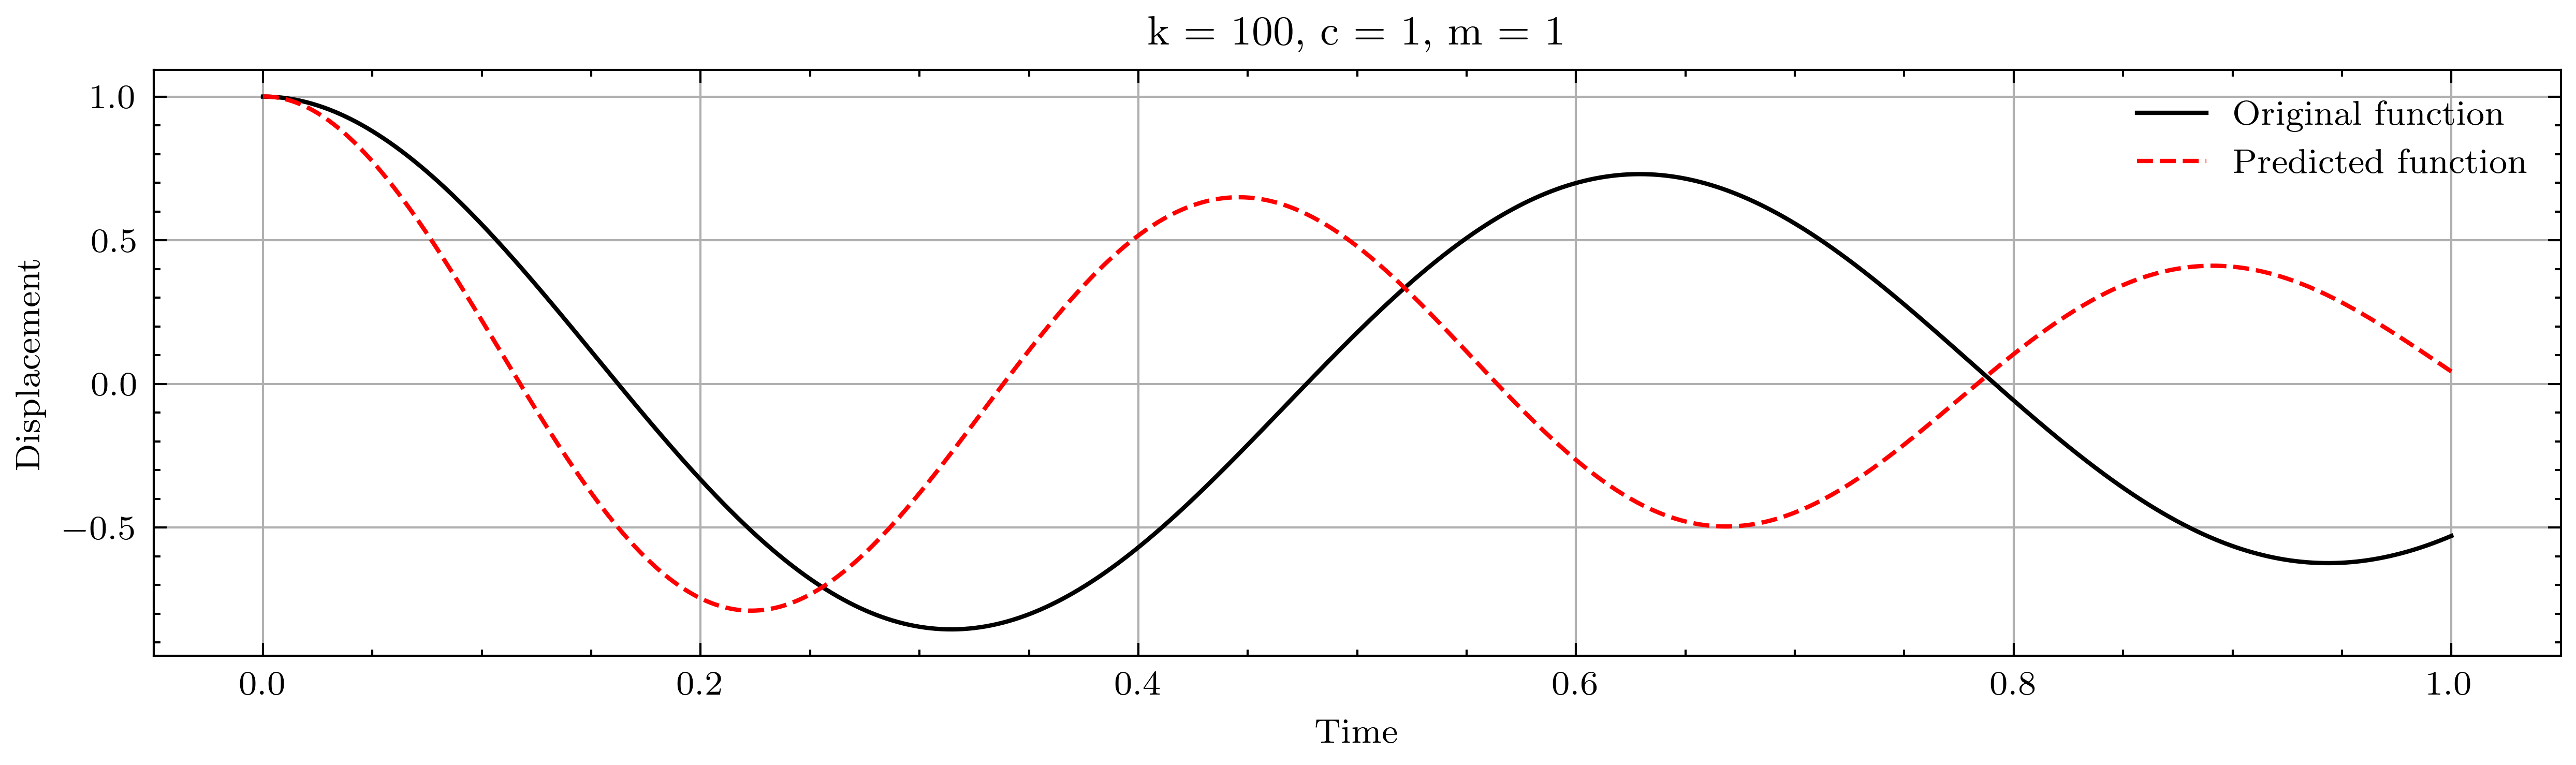

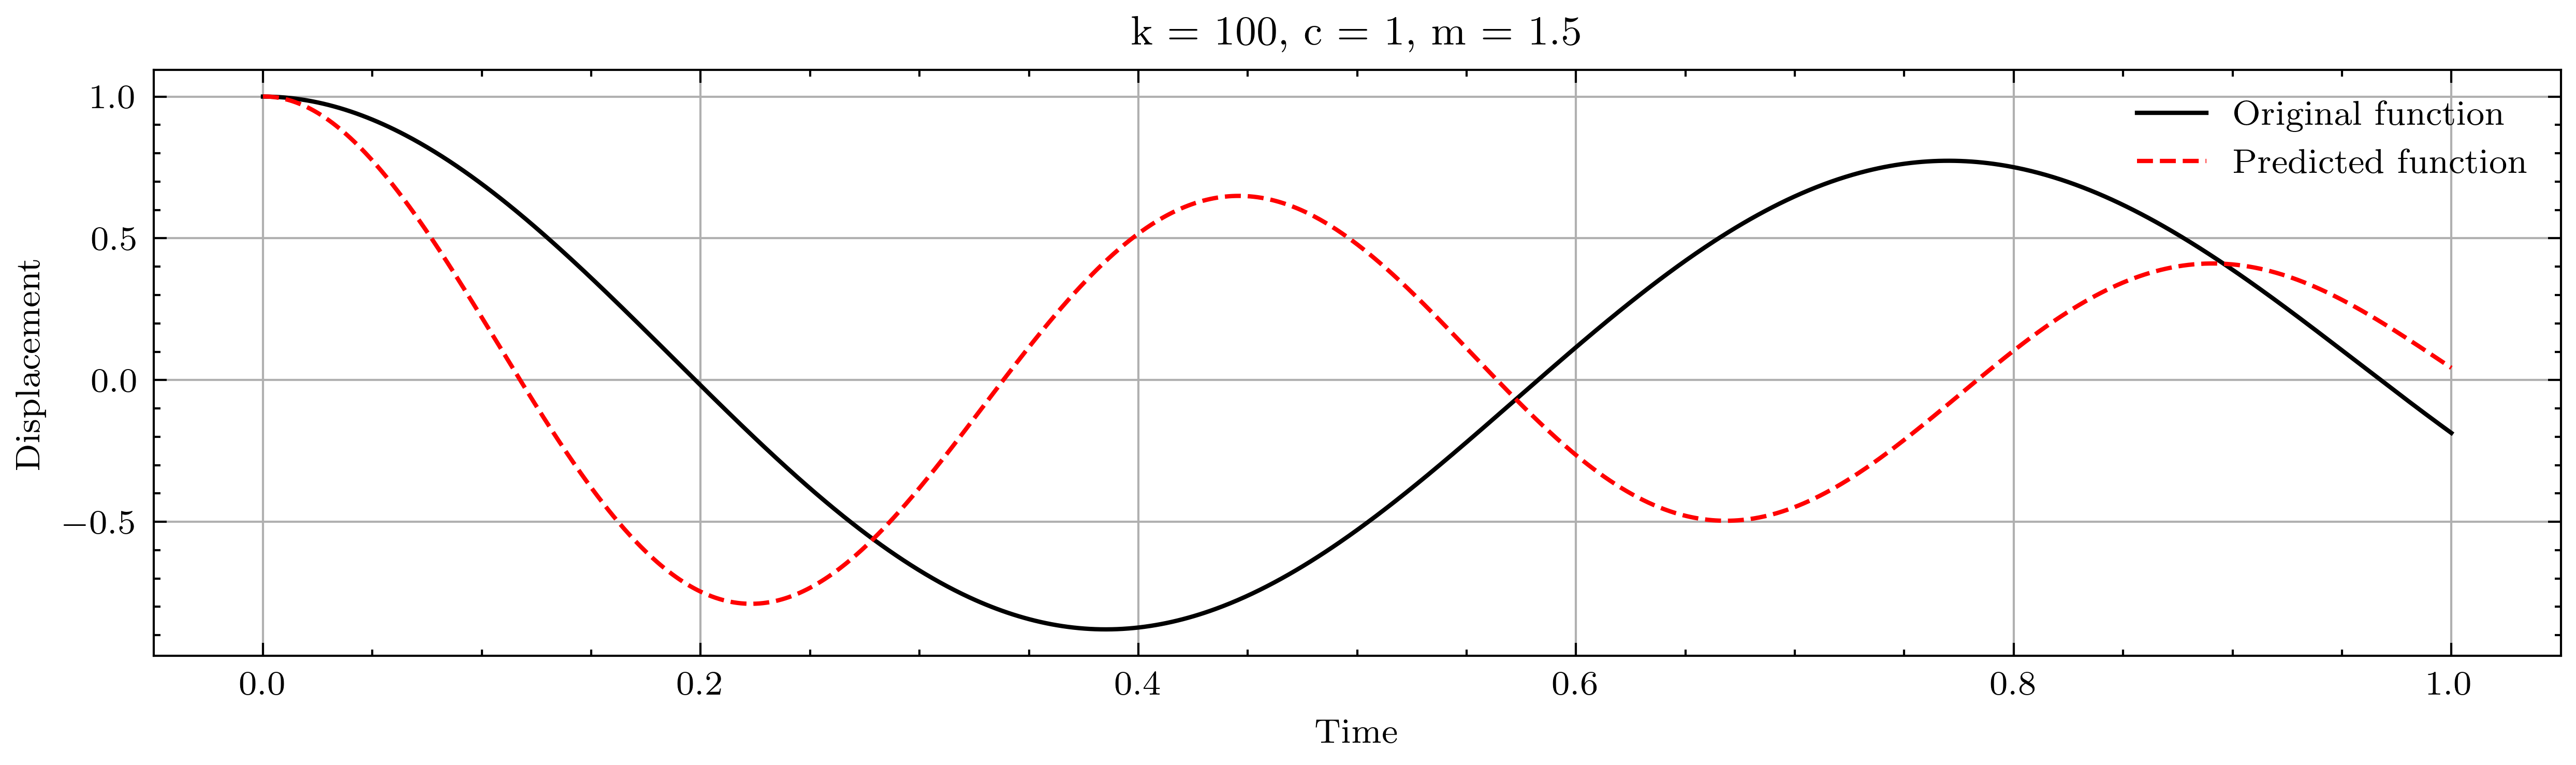

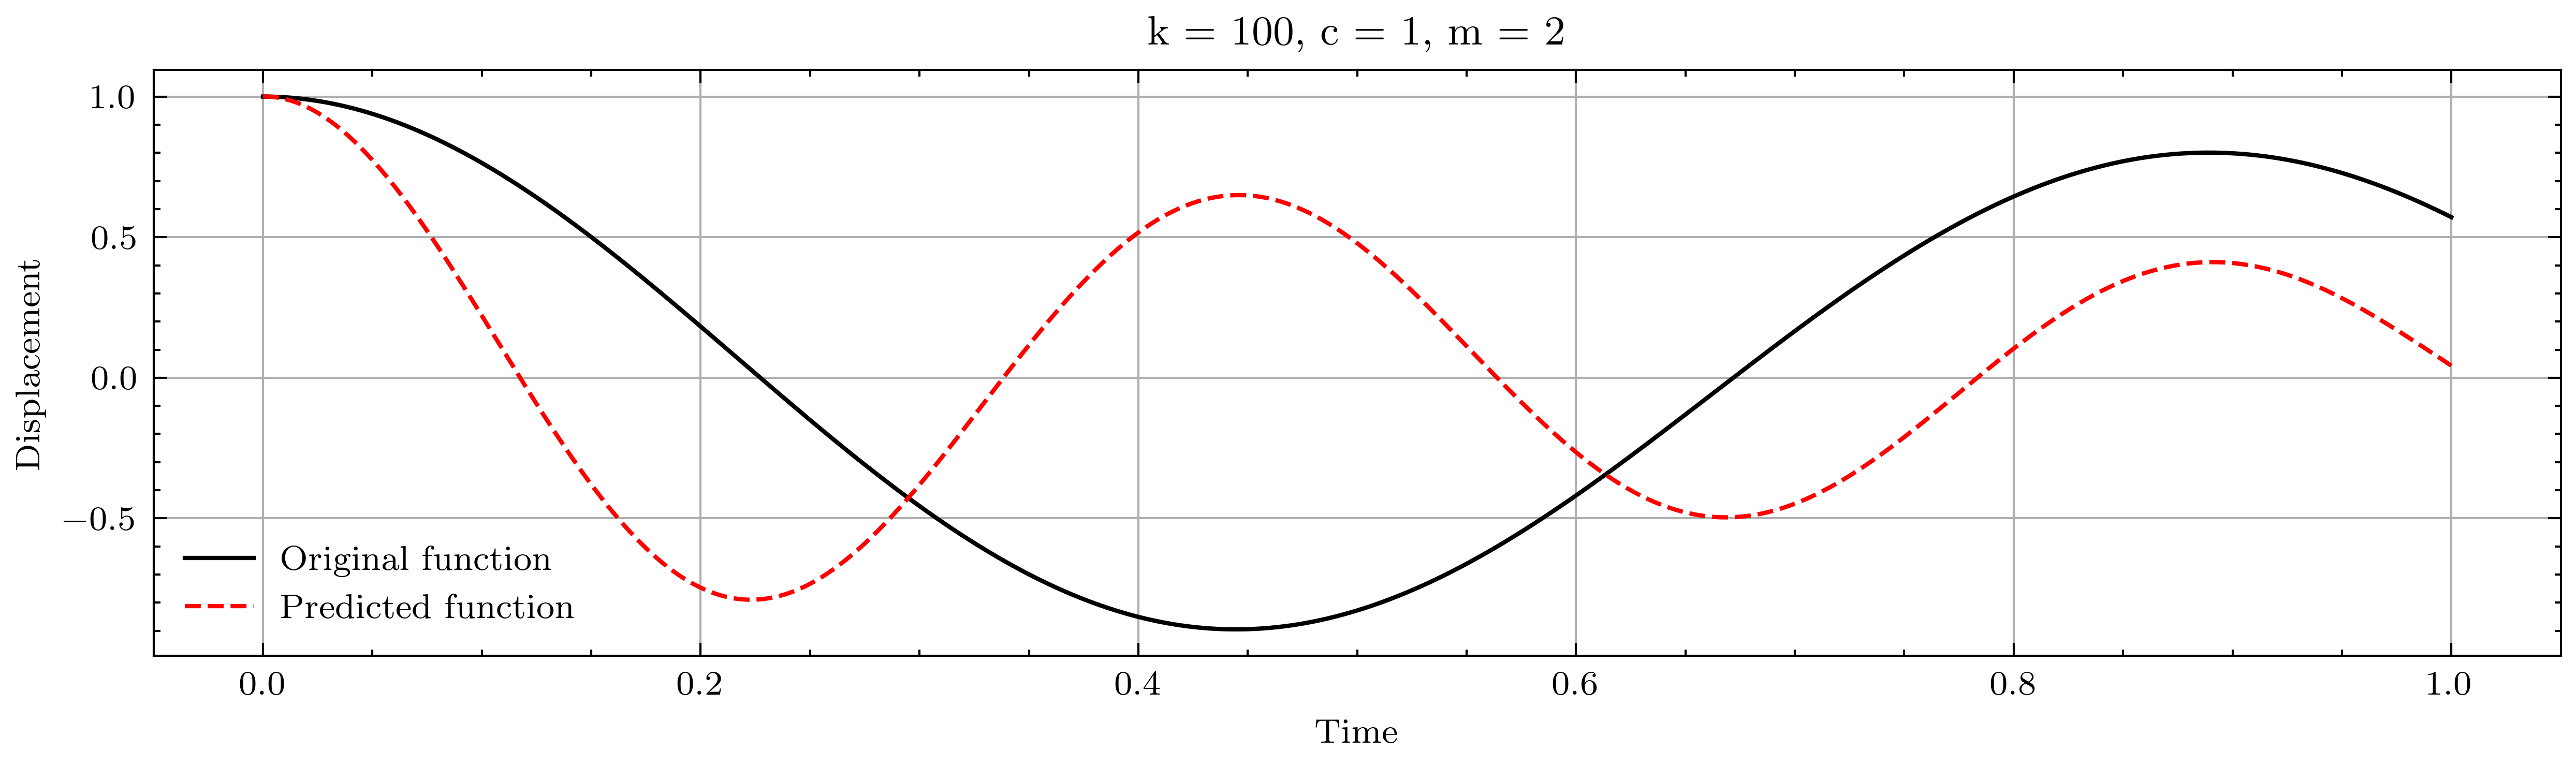

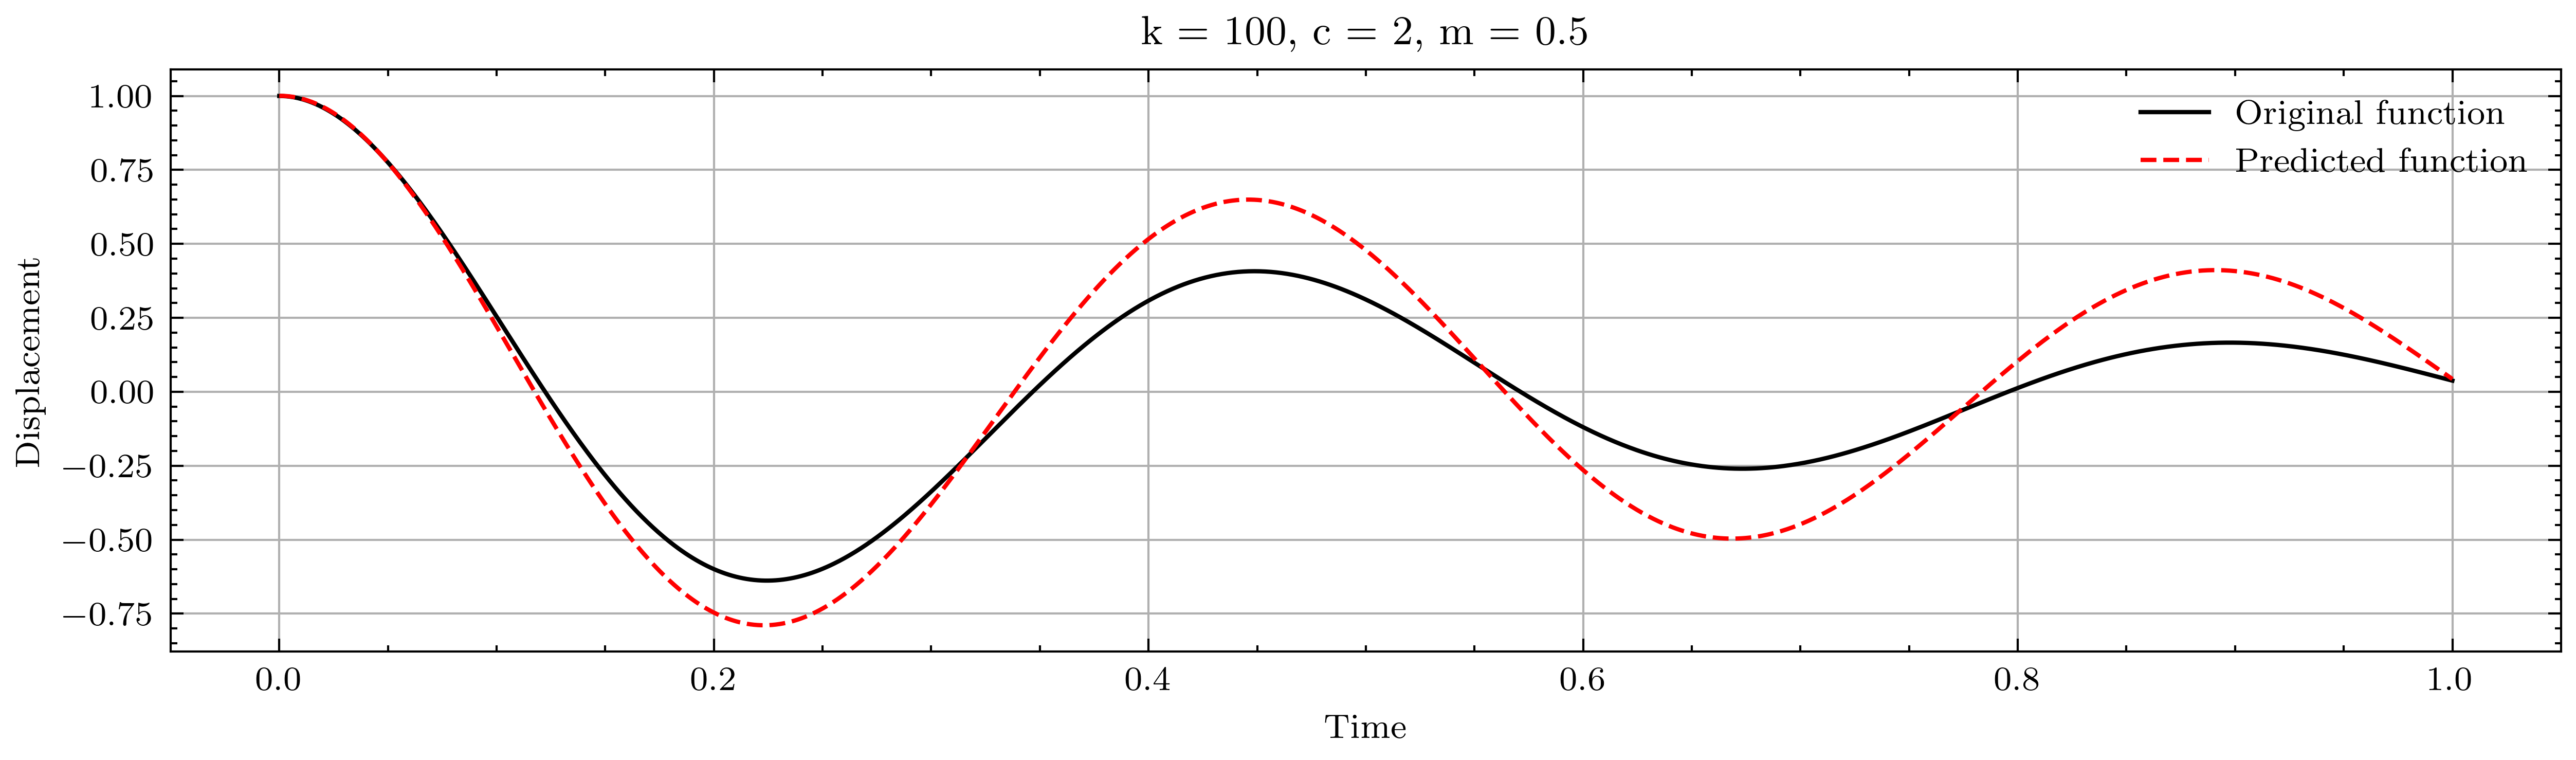

In [3]:
# Loop through the first 5 combinations in testing_data and evaluate the model's predictions.
for i, (k, c, m, t_test, x_test) in enumerate(testing_data[:5]):
    model.eval()
    predictions = model(t_test)
    
    # Plot the original function and the predicted function
    fig, ax = plt.subplots(figsize=(10, 2.5))
    ax.plot(t_test.detach().numpy(), x_test.detach().numpy(), label='Original function')
    ax.plot(t_test.detach().numpy(), predictions.detach().numpy(), label='Predicted function', color='red')
    ax.set_xlabel('Time')
    ax.set_ylabel('Displacement')
    plt.title(f'k = {k}, c = {c}, m = {m}')  # Add title with parameters
    plt.grid()
    plt.legend()
    plt.show()
